# Basic DMDB Analysis

In [1]:
import pandas as pd
import networkx as nx
import re
import yaml
from itertools import chain
from pathlib import Path
from operator import itemgetter
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
from path_plots.dmdb_plots import plot_path
from data_tools.files import download
from data_tools.plotting import count_plot_h, venn2_pretty, venn3_pretty

/Users/hanbing/opt/anaconda3/lib/python3.9/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
#!pip install git+https://github.com/mmayers12/path_plots
#!pip install git+https://github.com/mmayers12/data_tools

In [3]:
# Make the output folders
this_name = '1_basic_dmdb_analysis'
out_dir = Path('../2_pipeline').joinpath(this_name, 'out').resolve()
out_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path('../0_data/external').resolve()
data_dir.mkdir(parents=True, exist_ok=True)

In [4]:
DMDB_URL = 'https://raw.githubusercontent.com/SuLab/DrugMechDB/main/indication_paths.yaml'
download(DMDB_URL, data_dir.joinpath('indication_paths.yaml'), redownload=False)

File indication_paths.yaml exits. Skipping...


In [5]:
with open(data_dir.joinpath('indication_paths.yaml'), 'r') as fh:
        ind = yaml.safe_load(fh)

In [6]:
def path_to_tup(path):
    return (path['graph']['drugbank'], path['graph']['disease_mesh'])

def path_to_G(path):
    return nx.node_link_graph(path)       # Returns graph from node-link data format.                                                                                

def get_all_paths(path):
    source_id = path['links'][0]['source'] # drug id                                                                             
    target_ids = list(set([l['target'] for l in path['links']]) - set([l['source'] for l in path['links']])) # a-b 集合a中包含而集合b中不包含的元素
    # final target id
    G = path_to_G(path)
    this_paths = list(chain(*[list(nx.all_simple_paths(G, source_id, target_id)) for target_id in target_ids]))  #
    #Generate all simple paths in the graph G from source to target.
    # chain (*iterables)
    return this_paths

def get_id_to_type(G):
    id_to_type = {}
    for n in G.nodes.data():
        id_to_type[n[0]] = n[1]['label']
    return id_to_type

def get_id_to_name(G):
    id_to_name = {}
    for n in G.nodes.data():
        id_to_name[n[0]] = n[1]['name']
    return id_to_name

def add_metaedges(G): # export the simple relationship drug-decreases-disease such things
    id_to_type = get_id_to_type(G)
    for e in G.edges:
        G.edges[e]['metaedge'] = id_to_type[e[0]] + ' - ' + e[2] + ' - ' + id_to_type[e[1]]
    return G

def add_meanode_pairs(G): # export the simple relationship drug-disease such things
    id_to_type = get_id_to_type(G)
    for e in G.edges:
        G.edges[e]['mn_pair'] = id_to_type[e[0]] + ' - ' + id_to_type[e[1]]
    return G

def get_targets(G):
    drug = list(G.edges)[0][0]
    targets = []
    for e in G.edges:
        if e[0] == drug:
            targets.append(e[1])
    return targets

def get_target_metaedges(G):
    drug = list(G.edges)[0][0]
    target_mes = []
    if 'metaedge' not in G.edges[list(G.edges)[0]]:
        G = add_metaedges(G)
    
    for e in G.edges:
        if e[0] == drug:
            target_mes.append(G.edges[e]['metaedge'])
    return target_mes

In [16]:
drug_id, dis_id = path_to_tup(ind[0]) # extract the drug id and disease id
paths = get_all_paths(ind[0])
G = path_to_G(ind[0])
G = add_metaedges(G)
G = add_meanode_pairs(G)
    

In [20]:
ind[0]

{'directed': True,
 'graph': {'_id': 'DB00619_MESH_D015464_1',
  'disease': 'CML (ph+)',
  'disease_mesh': 'MESH:D015464',
  'drug': 'imatinib',
  'drug_mesh': 'MESH:D000068877',
  'drugbank': 'DB:DB00619'},
 'links': [{'key': 'decreases activity of',
   'source': 'MESH:D000068877',
   'target': 'UniProt:P00519'},
  {'key': 'causes', 'source': 'UniProt:P00519', 'target': 'MESH:D015464'}],
 'multigraph': True,
 'nodes': [{'id': 'MESH:D000068877', 'label': 'Drug', 'name': 'imatinib'},
  {'id': 'UniProt:P00519', 'label': 'Protein', 'name': 'BCR/ABL'},
  {'id': 'MESH:D015464', 'label': 'Disease', 'name': 'CML (ph+)'}]}

In [17]:
paths

[['MESH:D000068877', 'UniProt:P00519', 'MESH:D015464']]

In [7]:
# test
a=ind[1] # id is the whole ymal, and each cell is one drug--disease pair
a['links']
#target_ids = list(set([l['target'] for l in a['links']]) - set([l['source'] for l in a['links']]))


[{'key': 'decreases activity of',
  'source': 'MESH:D000068877',
  'target': 'UniProt:P10721'},
 {'key': 'decreases activity of',
  'source': 'MESH:D000068877',
  'target': 'UniProt:P16234'},
 {'key': 'positively regulates',
  'source': 'UniProt:P10721',
  'target': 'GO:0008283'},
 {'key': 'positively regulates',
  'source': 'UniProt:P16234',
  'target': 'GO:0008283'},
 {'key': 'causes', 'source': 'GO:0008283', 'target': 'MESH:D034721'}]

In [9]:
# test
path = ind[1]
source_id = path['links'][0]['source'] # drug id                                                                             
target_ids = list(set([l['target'] for l in path['links']]) - set([l['source'] for l in path['links']])) # a-b 集合a中包含而集合b中不包含的元素
print(target_ids)
G = path_to_G(path)
print(G)
this_paths = list(chain(*[list(nx.all_simple_paths(G, source_id, target_id)) for target_id in target_ids])) 
# chain (*iterables)
print(this_paths)
print(G.nodes.data)
id_to_name = {}
for n in G.nodes.data():
    id_to_name[n[0]] = n[1]['name']

['MESH:D034721']
MultiDiGraph with 5 nodes and 5 edges
[['MESH:D000068877', 'UniProt:P10721', 'GO:0008283', 'MESH:D034721'], ['MESH:D000068877', 'UniProt:P16234', 'GO:0008283', 'MESH:D034721']]
<bound method NodeView.data of NodeView(('MESH:D000068877', 'UniProt:P10721', 'UniProt:P16234', 'GO:0008283', 'MESH:D034721'))>


In [10]:
# test
print(id_to_name)

{'MESH:D000068877': 'imatinib', 'UniProt:P10721': 'c-Kit', 'UniProt:P16234': 'Pdgf', 'GO:0008283': 'Cellular proliferation', 'MESH:D034721': 'Systemic mast cell disease'}


In [11]:
# test
for n in G.nodes.data():
    print(n)
    # label and name are attributes

('MESH:D000068877', {'label': 'Drug', 'name': 'imatinib'})
('UniProt:P10721', {'label': 'Protein', 'name': 'c-Kit'})
('UniProt:P16234', {'label': 'Protein', 'name': 'Pdgf'})
('GO:0008283', {'label': 'BiologicalProcess', 'name': 'Cellular proliferation'})
('MESH:D034721', {'label': 'Disease', 'name': 'Systemic mast cell disease'})


In [12]:
# test
id_to_type = get_id_to_type(G)
for e in G.edges:
    print(e)
    training = e
    print(training[2])
    G.edges[e]['metaedge'] = id_to_type[e[0]] + ' - ' + e[2] + ' - ' + id_to_type[e[1]]
    print(G.edges[e]['metaedge'])
print(G.edges)
print(G.edges[('MESH:D000068877', 'UniProt:P10721', 'decreases activity of')]['metaedge'])

('MESH:D000068877', 'UniProt:P10721', 'decreases activity of')
decreases activity of
Drug - decreases activity of - Protein
('MESH:D000068877', 'UniProt:P16234', 'decreases activity of')
decreases activity of
Drug - decreases activity of - Protein
('UniProt:P10721', 'GO:0008283', 'positively regulates')
positively regulates
Protein - positively regulates - BiologicalProcess
('UniProt:P16234', 'GO:0008283', 'positively regulates')
positively regulates
Protein - positively regulates - BiologicalProcess
('GO:0008283', 'MESH:D034721', 'causes')
causes
BiologicalProcess - causes - Disease
[('MESH:D000068877', 'UniProt:P10721', 'decreases activity of'), ('MESH:D000068877', 'UniProt:P16234', 'decreases activity of'), ('UniProt:P10721', 'GO:0008283', 'positively regulates'), ('UniProt:P16234', 'GO:0008283', 'positively regulates'), ('GO:0008283', 'MESH:D034721', 'causes')]
Drug - decreases activity of - Protein


In [13]:
# test
G = path_to_G(path)
G.add_node(1)
G.add_nodes_from([2,4,'s'])
print(list(G.nodes))
G.add_edges_from([(1, 4), (1, 's')])
print(list(G.edges))

['MESH:D000068877', 'UniProt:P10721', 'UniProt:P16234', 'GO:0008283', 'MESH:D034721', 1, 2, 4, 's']
[('MESH:D000068877', 'UniProt:P10721', 'decreases activity of'), ('MESH:D000068877', 'UniProt:P16234', 'decreases activity of'), ('UniProt:P10721', 'GO:0008283', 'positively regulates'), ('UniProt:P16234', 'GO:0008283', 'positively regulates'), ('GO:0008283', 'MESH:D034721', 'causes'), (1, 4, 0), (1, 's', 0)]


In [14]:
#test 
id_to_type = get_id_to_type(G)
for e in G.edges:
    G.edges[e]['mn_pair'] = id_to_type[e[0]] + ' - ' + id_to_type[e[1]]
    print(G.edges[e]['mn_pair'])
    print (G.edges[e])

    append(" - ".join([n[1]['label'] for n in G.nodes.data()]))

KeyError: 'label'

In [ ]:
# test
c = []
c.append(" - ".join(str(n) for n in ['?',2,3,4]))
c

re.sub(" - [^-]*$"," - ",training[2]['metaedge'])

### Things we'll explore in this notebook

-  Number of paths
-  Longest Path
-  Shortest path
-  Number of nodes
-  Number of edges

- most common metaedge
- most common pairing
- most common node
- common targets
- First edge type

In [15]:
basic_stats = defaultdict(list)
all_metaedges = []
all_parings = []
all_targets = []
unique_metaedges = []
first_edge_type = []
all_nodes = []

id_to_name = {}
id_to_label = {}

for i, p in enumerate(ind):
    drug_id, dis_id = path_to_tup(p) # extract the drug id and disease id
    paths = get_all_paths(p)
    G = path_to_G(p)
    
    G = add_metaedges(G)
    G = add_meanode_pairs(G)
    
    basic_stats['idx'].append(i)
    basic_stats['id'].append(p['graph']['_id'])
    basic_stats['drug'].append(drug_id)
    basic_stats['disease'].append(dis_id)
    basic_stats['n_nodes'].append(len(G.nodes))
    basic_stats['n_edges'].append(len(G.edges))
    basic_stats['n_paths'].append(len(paths))
    basic_stats['longest_path'].append(max([len(p) for p in paths]))
    basic_stats['shortest_path'].append(max([len(p) for p in paths]))
    basic_stats['metapath'].append(" - ".join([n[1]['label'] for n in G.nodes.data()]))
    basic_stats['metapath_with_edges'].append("".join([re.sub(" - [^-]*$"," - ",e[2]['metaedge']) for e in G.edges.data()])+"Disease")
    # re is a package to check whether strs are matched
    # re.sub(pattern, repl, string, count=0, flags=0) to replace some things
    #You can match the characters not listed within the class by complementing the set. 
    #This is indicated by including a '^' as the first character of the class. For example, [^5] will match any character except '5'. 
    #Notice that the . needs to be treated specially because it’s a metacharacter, so it’s inside a character class to only match that specific character. 
    #Also notice the trailing $; this is added to ensure that all the rest of the string must be included in the extension.
    # result = re.sub('abc',  'def', input)           # Replace pattern abc -> def
    # e[2]: decreases activity of 
    #  \s*$                # Trailing whitespace to end-of-line
    # each e in G.edges.data()： ('MESH:D000068877', 'UniProt:P10721', {'metaedge': 'Drug - decreases activity of - Protein', 'mn_pair': 'Drug - Protein'})
    # e[2]: {'metaedge': 'Drug - decreases activity of - Protein', 'mn_pair': 'Drug - Protein'}
    # e[2]['metaedge']: 'Drug - decreases activity of - Protein'
    # re.sub(" - [^-]*$"," - ",training[2]['metaedge']): 'Drug - decreases activity of - '
    this_metaedges = [G.edges[e]['metaedge'] for e in G.edges]
    all_metaedges += this_metaedges
    unique_metaedges += list(set(this_metaedges))
    
    all_parings += [G.edges[e]['mn_pair'] for e in G.edges]
    all_targets += get_targets(G)
    first_edge_type += get_target_metaedges(G)
    all_nodes += list(G.nodes)
    
    id_to_label = {**id_to_label, **get_id_to_type(G)}
    id_to_name = {**id_to_name, **get_id_to_name(G)}
    
basic_stats = pd.DataFrame(basic_stats)

In [16]:
basic_stats

,idx,id,drug,disease,n_nodes,n_edges,n_paths,longest_path,shortest_path,metapath,metapath_with_edges
0,0,DB00619_MESH_D015464_1,DB:DB00619,MESH:D015464,3,2,1,3,3,Drug - Protein - Disease,Drug - decreases activity of - Protein - cause...
1,1,DB00619_MESH_D034721_1,DB:DB00619,MESH:D034721,5,5,2,4,4,Drug - Protein - Protein - BiologicalProcess -...,Drug - decreases activity of - Drug - decrease...
2,2,DB00316_MESH_D010146_1,DB:DB00316,MESH:D010146,6,7,3,4,4,Drug - Protein - Protein - Pathway - ChemicalS...,Drug - decreases activity of - Drug - decrease...
3,3,DB00316_MESH_D005334_1,DB:DB00316,MESH:D005334,5,4,1,5,5,Drug - Pathway - GrossAnatomicalStructure - Bi...,Drug - negatively regulates - Pathway - occurs...
4,4,DB00945_MESH_D010146_1,DB:DB00945,MESH:D010146,5,5,2,4,4,Drug - Protein - Protein - ChemicalSubstance -...,Drug - decreases activity of - Drug - decrease...
...,...,...,...,...,...,...,...,...,...,...,...
3607,3607,DB00863_MESH_D006356_1,DB:DB00863,MESH:D006356,5,4,1,5,5,Drug - Protein - BiologicalProcess - ChemicalS...,Drug - decreases activity of - Protein - posit...
3608,3608,DB00863_MESH_D004415_1,DB:DB00863,MESH:D004415,6,5,1,6,6,Drug - Protein - BiologicalProcess - ChemicalS...,Drug - decreases activity of - Protein - posit...
3609,3609,DB00863_MESH_D015043_1,DB:DB00863,MESH:D015043,6,5,1,6,6,Drug - Protein - BiologicalProcess - ChemicalS...,Drug - decreases activity of - Protein - posit...
3610,3610,DB00989_MESH_D000544_1,DB:DB00989,MESH:D000544,6,6,2,5,5,Drug - Protein - ChemicalSubstance - Biologica...,Drug - decreases activity of - Drug - decrease...


In [17]:
print("Number of unique drugs: " + str(len(set(basic_stats['drug']))))
print("Number of unique diseases: " + str(len(set(basic_stats['disease']))))
print("Number of unique drug-disease combinations: " + str(len(basic_stats.groupby(['drug','disease']).size())))


Number of unique drugs: 1499
Number of unique diseases: 663
Number of unique drug-disease combinations: 3344


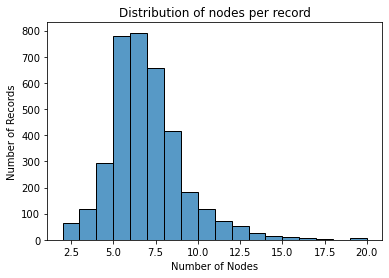

In [18]:
sns.histplot(basic_stats['n_nodes'],binwidth=1)
plt.title('Distribution of nodes per record')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Records');

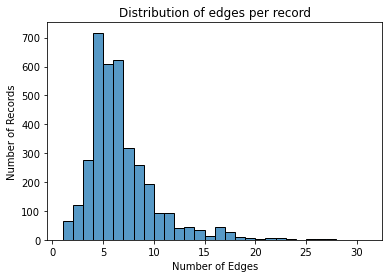

In [19]:
sns.histplot(basic_stats['n_edges'],binwidth=1)
plt.title('Distribution of edges per record')
plt.xlabel('Number of Edges')
plt.ylabel('Number of Records');

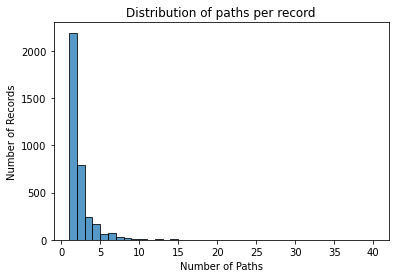

In [20]:
sns.histplot(basic_stats['n_paths'],binwidth=1)
plt.title('Distribution of paths per record')
plt.xlabel('Number of Paths')
plt.ylabel('Number of Records');

In [21]:
basic_stats.query('n_paths > 20')

,idx,id,drug,disease,n_nodes,n_edges,n_paths,longest_path,shortest_path,metapath,metapath_with_edges
724,724,DB05219_MESH_D003876_1,DB:DB05219,MESH:D003876,14,25,40,6,6,Drug - Protein - Protein - Protein - Protein -...,Drug - negatively regulates - Drug - negativel...
2442,2442,DB00806_MESH_D016491_1,DB:DB00806,MESH:D016491,19,26,24,9,9,Drug - Protein - ChemicalSubstance - Biologica...,Drug - decreases activity of - Drug - decrease...


/Users/hanbing/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


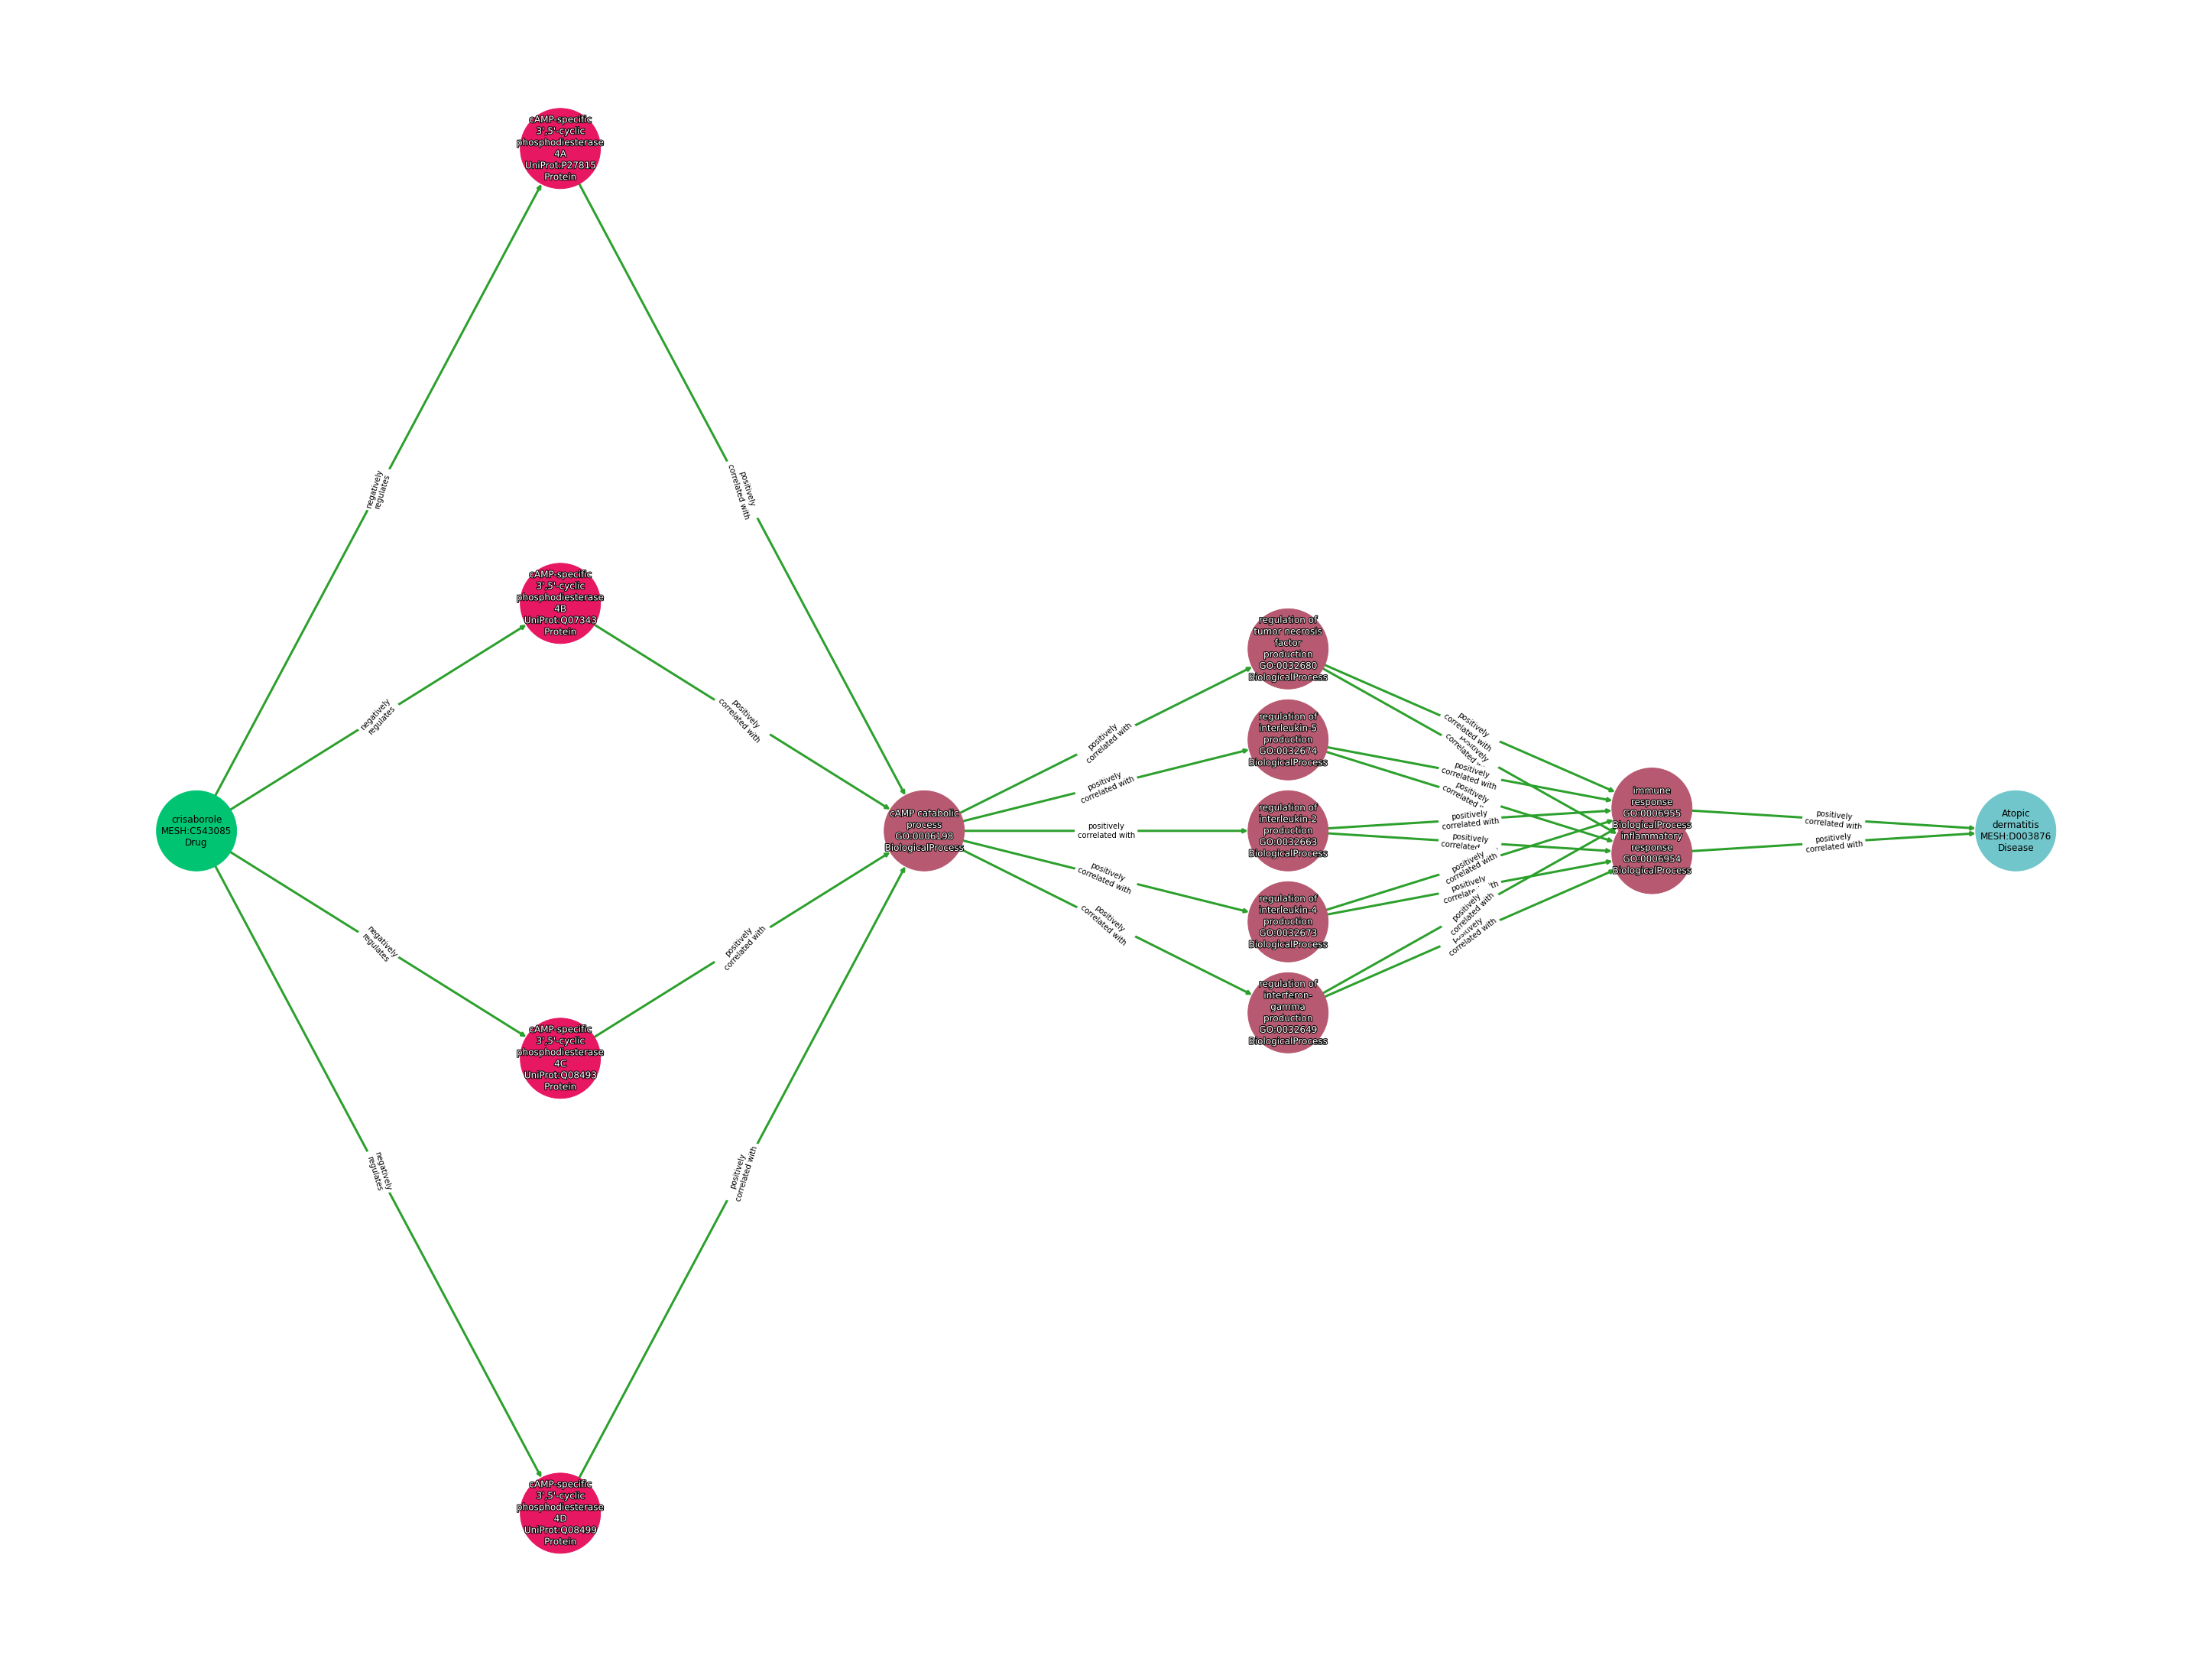

In [22]:
f = plot_path(ind[724])
f.set_size_inches(40, 30)

In [27]:
basic_stats.query('shortest_path==2')

,idx,id,drug,disease,n_nodes,n_edges,n_paths,longest_path,shortest_path,metapath,metapath_with_edges
60,60,DB01527_MESH_D000856_1,DB:DB01527,MESH:D000856,2,2,2,2,2,Drug - Disease,Drug - treats - Drug - contraindicated for - D...
69,69,DB02362_MESH_D010392_1,DB:DB02362,MESH:D010392,2,1,1,2,2,Drug - Disease,Drug - treats - Disease
105,105,DB11254_MESH_D014010_1,DB:DB11254,MESH:D014010,2,1,1,2,2,Drug - Disease,Drug - treats - Disease
110,110,DB00253_MESH_D003320_1,DB:DB00253,MESH:D003320,2,1,1,2,2,Drug - Disease,Drug - treats - Disease
112,112,DB00253_MESH_D012393_1,DB:DB00253,MESH:D012393,2,1,1,2,2,Drug - Disease,Drug - treats - Disease
...,...,...,...,...,...,...,...,...,...,...,...
3139,3139,DB12710_MESH_D001196_1,DB:DB12710,MESH:D001196,2,1,1,2,2,Drug - Disease,Drug - treats - Disease
3272,3272,DB00126_MESH_D001206_1,DB:DB00126,MESH:D001206,2,1,1,2,2,Drug - Disease,Drug - treats - Disease
3292,3292,DB01914_MESH_D007003_1,DB:DB01914,MESH:D007003,2,1,1,2,2,Drug - Disease,Drug - treats - Disease
3313,3313,DB00131_MESH_D003550_1,DB:DB00131,MESH:D003550,2,1,1,2,2,Drug - Disease,Drug - treats - Disease


In [26]:
basic_stats.query('n_paths > 10')

,idx,id,drug,disease,n_nodes,n_edges,n_paths,longest_path,shortest_path,metapath,metapath_with_edges
397,397,DB08896_MESH_D006528_1,DB:DB08896,MESH:D006528,11,16,12,5,5,Disease - Protein - Protein - Protein - Protei...,Disease - decreases activity of - Disease - de...
517,517,DB00799_MESH_D000152_1,DB:DB00799,MESH:D000152,13,31,20,5,5,Drug - Protein - Protein - Protein - Protein -...,Drug - increases activity of - Drug - increase...
518,518,DB00799_MESH_D011565_1,DB:DB00799,MESH:D011565,10,20,12,5,5,Drug - Protein - Protein - Protein - Protein -...,Drug - increases activity of - Drug - increase...
724,724,DB05219_MESH_D003876_1,DB:DB05219,MESH:D003876,14,25,40,6,6,Drug - Protein - Protein - Protein - Protein -...,Drug - negatively regulates - Drug - negativel...
733,733,DB12323_MESH_D015464_1,DB:DB12323,MESH:D015464,10,17,12,5,5,Drug - Protein - Protein - GeneFamily - Molecu...,Drug - decreases activity of - Drug - decrease...
1204,1204,DB11348_MESH_D010024_1,DB:DB11348,MESH:D010024,17,23,14,11,11,Drug - ChemicalSubstance - GeneFamily - Protei...,Drug - derives into - Drug - derives into - Ch...
1205,1205,DB11348_MESH_D006996_1,DB:DB11348,MESH:D006996,17,23,14,11,11,Drug - ChemicalSubstance - GeneFamily - Protei...,Drug - derives into - Drug - derives into - Ch...
1206,1206,DB11348_MESH_D015663_1,DB:DB11348,MESH:D015663,17,23,14,11,11,Drug - ChemicalSubstance - GeneFamily - Protei...,Drug - derives into - Drug - derives into - Ch...
1253,1253,DB00484_MESH_D012393_1,DB:DB00484,MESH:D012393,11,16,12,7,7,Drug - Protein - Protein - Protein - Pathway -...,Drug - increases activity of - Drug - increase...
1272,1272,DB00484_MESH_D005902_2,DB:DB00484,MESH:D005902,12,17,12,8,8,Drug - Protein - Protein - Protein - Pathway -...,Drug - increases activity of - Drug - increase...


In [32]:
data_dir

PosixPath('/Users/hanbing/Dropbox (Scripps Research)/Hanbing Shen’s files/Su lab/DMDB_Analysis-main/0_data/external')

In [31]:
basic_stats.to_csv(data_dir.joinpath('basic_stats.csv'))

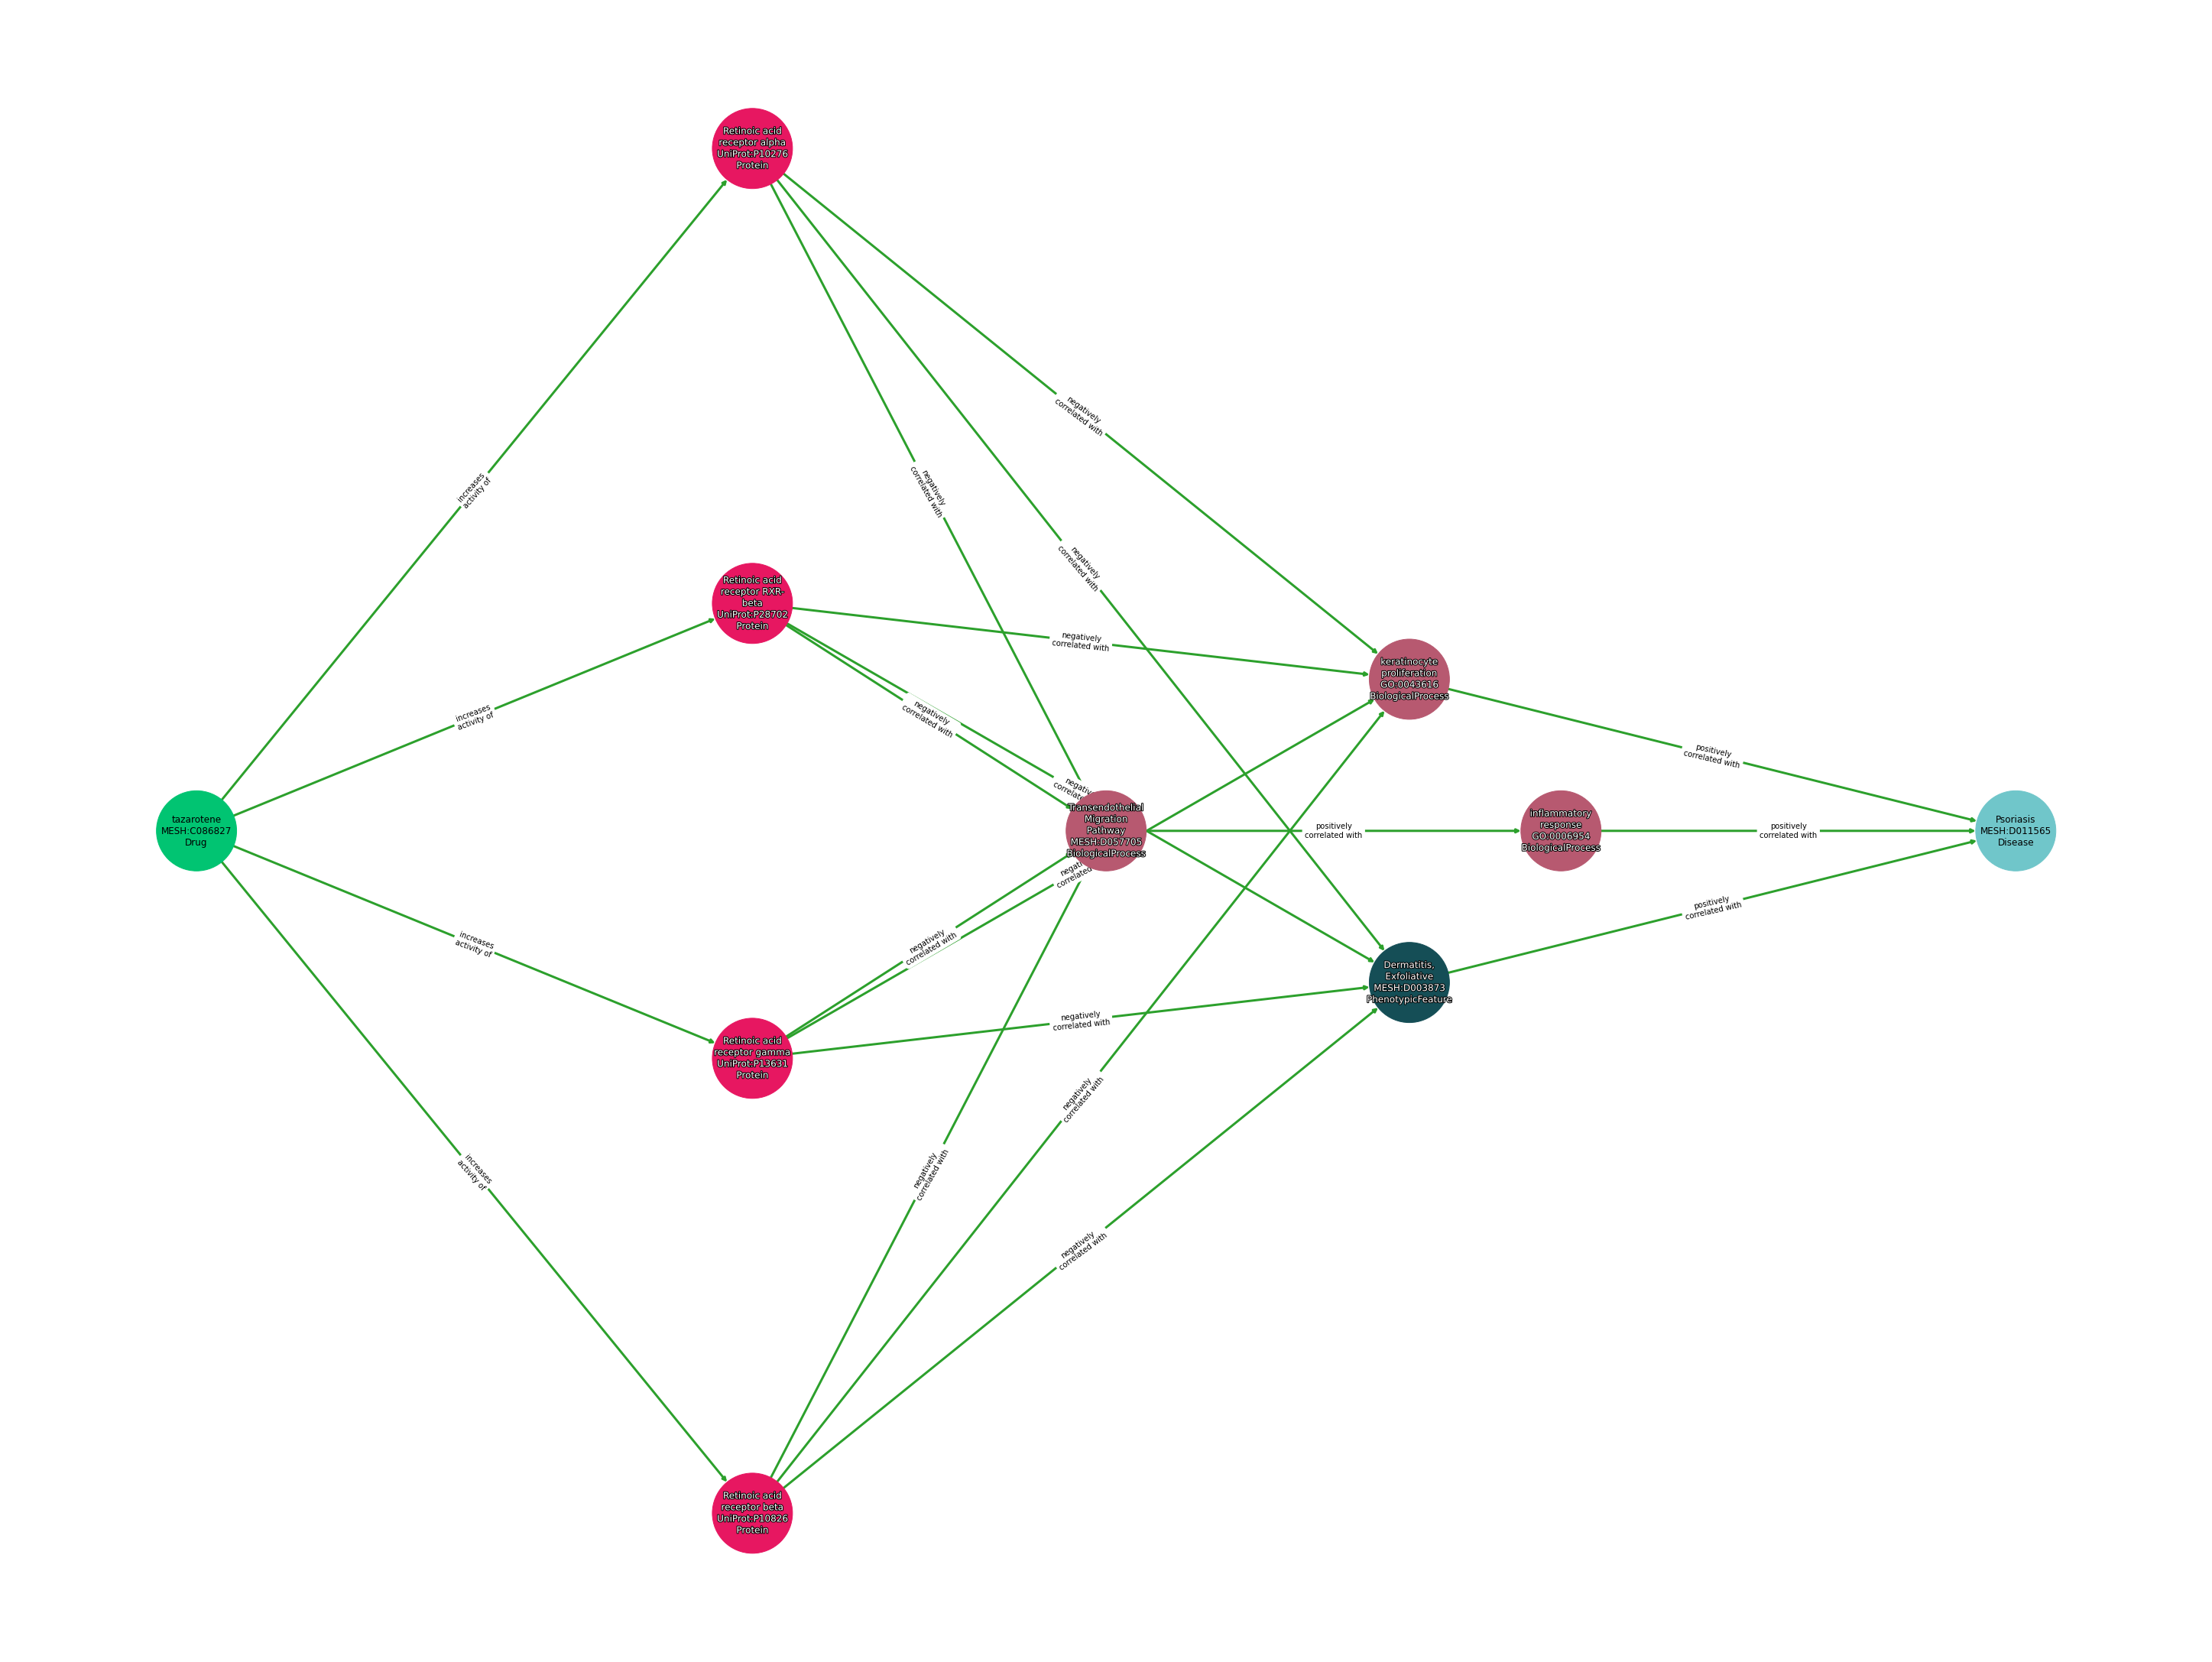

In [24]:
f = plot_path(ind[518])
f.set_size_inches(40, 30)

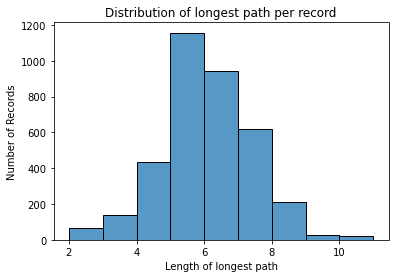

In [25]:
sns.histplot(basic_stats['longest_path'],binwidth=1)
plt.title('Distribution of longest path per record')
plt.xlabel('Length of longest path')
plt.ylabel('Number of Records');

#### Metanode parings

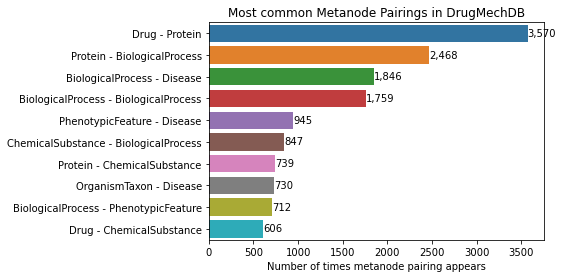

In [22]:
pair_counts = pd.Series(all_parings).value_counts()
count_plot_h(pair_counts.head(10))
plt.title('Most common Metanode Pairings in DrugMechDB')
plt.xlabel('Number of times metanode pairing appears');

#### Metaedge use

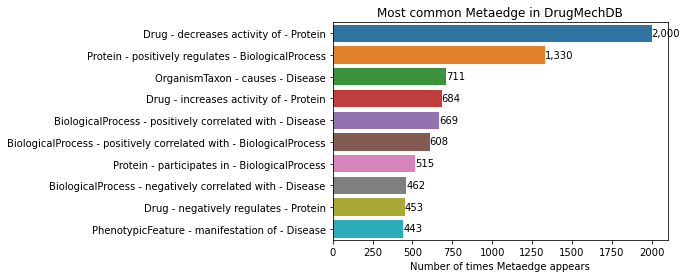

In [23]:
me_counts = pd.Series(all_metaedges).value_counts()
count_plot_h(me_counts.head(10))
plt.title('Most common Metaedge in DrugMechDB')
plt.xlabel('Number of times Metaedge appears');

#### Metaedges per record

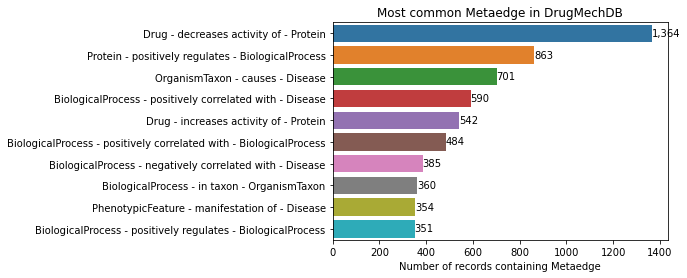

In [24]:
ume_counts = pd.Series(unique_metaedges).value_counts()
count_plot_h(ume_counts.head(10))
plt.title('Most common Metaedge in DrugMechDB')
plt.xlabel('Number of records containing Metaedge');

#### Metapaths

Text(0.5, 0, 'Number of records using metapath')

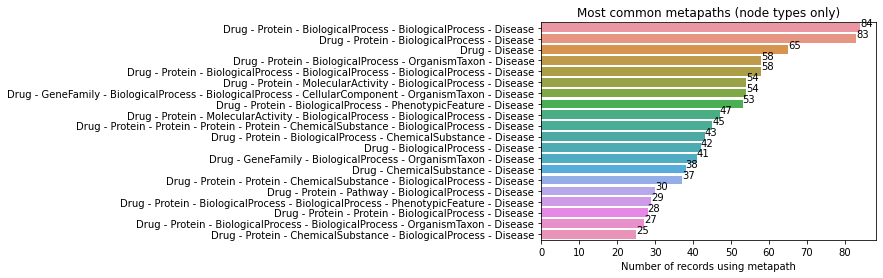

In [25]:
mp_counts = pd.Series(basic_stats['metapath']).value_counts()
count_plot_h(mp_counts.head(20))
plt.title('Most common metapaths (node types only)')
plt.xlabel('Number of records using metapath')

In [40]:
mp_counts.head(20)

Drug - Protein - BiologicalProcess - BiologicalProcess - Disease                                           84
Drug - Protein - BiologicalProcess - Disease                                                               83
Drug - Disease                                                                                             65
Drug - Protein - BiologicalProcess - OrganismTaxon - Disease                                               58
Drug - Protein - BiologicalProcess - BiologicalProcess - BiologicalProcess - Disease                       58
Drug - Protein - MolecularActivity - BiologicalProcess - Disease                                           54
Drug - GeneFamily - BiologicalProcess - BiologicalProcess - CellularComponent - OrganismTaxon - Disease    54
Drug - Protein - BiologicalProcess - PhenotypicFeature - Disease                                           53
Drug - Protein - MolecularActivity - BiologicalProcess - BiologicalProcess - Disease                       47
Drug - Pro

<AxesSubplot:xlabel='metapath_with_edges'>

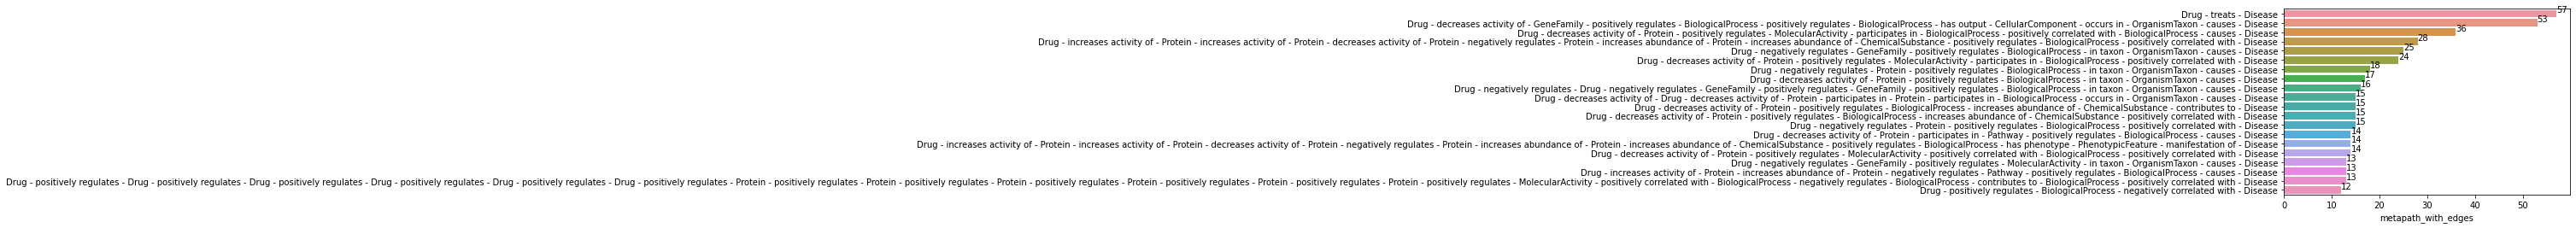

In [26]:
count_plot_h(basic_stats['metapath_with_edges'].value_counts().head(20))

In [27]:
basic_stats['metapath_with_edges'].value_counts().head(20)

Drug - treats - Disease                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                57
Drug - decreases activity of - GeneFamily - positively regulates - BiologicalProcess - positively regulates - BiologicalProcess - has output - CellularComponent - occurs in - OrganismTaxon - causes - Disease                                                                                                                                                                                                                               

## Node information

In [28]:
node_counts = pd.Series(all_nodes, name='id')
node_counts = node_counts.to_frame().reset_index()
node_counts['name'] = node_counts['id'].map(id_to_name)
node_counts['label'] = node_counts['id'].map(id_to_label)

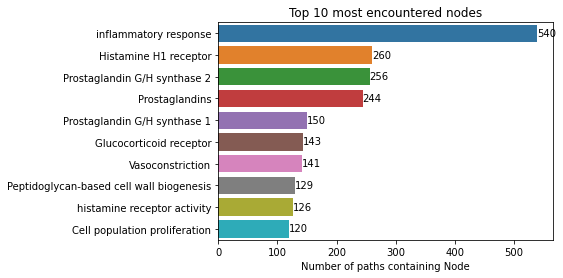

In [29]:
count_plot_h(node_counts['name'].value_counts().head(10))
plt.title('Top 10 most encountered nodes')
plt.xlabel('Number of paths containing Node')
plt.ylabel('');

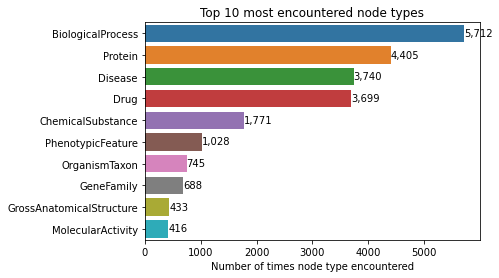

In [30]:
count_plot_h(node_counts['label'].value_counts().head(10))
plt.title('Top 10 most encountered node types')
plt.xlabel('Number of times node type encountered')
plt.ylabel('');

## Target Information

In [31]:
target_counts = pd.Series(all_targets, name='count')
target_counts = target_counts.value_counts().to_frame().reset_index().rename(columns={'index': 'id'})
target_counts['name'] = target_counts['id'].map(id_to_name)
target_counts['label'] = target_counts['id'].map(id_to_label)

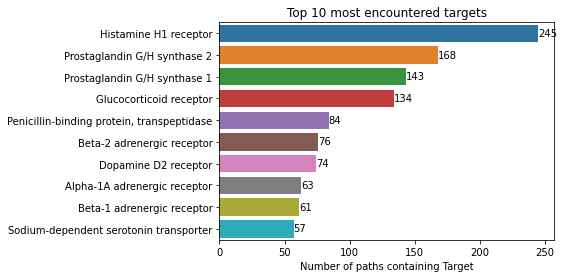

In [32]:
count_plot_h(target_counts.set_index('name').head(10)['count'])
plt.title('Top 10 most encountered targets')
plt.xlabel('Number of paths containing Target')
plt.ylabel('');

In [33]:
pd.Series(first_edge_type, name='type').to_frame()

,type
0,Drug - decreases activity of - Protein
1,Drug - decreases activity of - Protein
2,Drug - decreases activity of - Protein
3,Drug - decreases activity of - Protein
4,Drug - decreases activity of - Protein
...,...
5297,Drug - decreases activity of - Protein
5298,Drug - decreases activity of - Protein
5299,Drug - decreases activity of - ChemicalSubstance
5300,Drug - decreases activity of - Protein


In [34]:
fet_data = pd.Series(first_edge_type, name='type').to_frame()
fet_data['target_type'] = fet_data['type'].apply(lambda x: x.split(' - ')[2])
fet_data['interaction'] = fet_data['type'].apply(lambda x: x.split(' - ')[1])

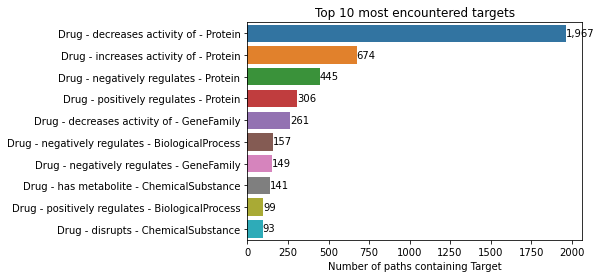

In [35]:
count_plot_h(fet_data['type'].value_counts().head(10))
plt.title('Top 10 most encountered targets')
plt.xlabel('Number of paths containing Target')
plt.ylabel('');

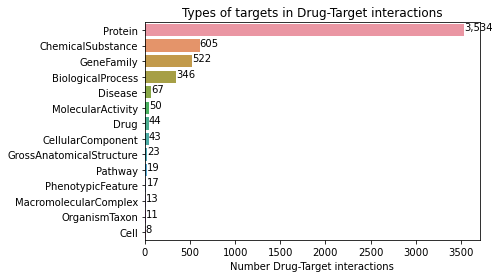

In [36]:
count_plot_h(fet_data['target_type'].value_counts())
plt.title('Types of targets in Drug-Target interactions')
plt.xlabel('Number Drug-Target interactions')
plt.ylabel('');

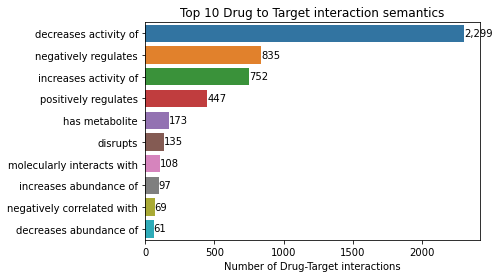

In [37]:
count_plot_h(fet_data['interaction'].value_counts().head(10))
plt.title('Top 10 Drug to Target interaction semantics')
plt.xlabel('Number of Drug-Target interactions')
plt.ylabel('');

## Full Graph Analysis

In [38]:
Graph = nx.MultiDiGraph()

for p in ind:
    G = path_to_G(p)
    Graph = nx.compose(Graph, G)

In [39]:
print(nx.info(Graph))

MultiDiGraph with 4857 nodes and 10125 edges


In [40]:
nx.density(Graph)

0.00042928750739010496

In [41]:
sgraph = nx.MultiGraph(Graph)

In [42]:
components = list(nx.connected_components(sgraph))
len(components)

21

In [43]:
larget_component = max(components, key=len)

In [44]:
subgraph = sgraph.subgraph(larget_component)

In [45]:
nx.diameter(subgraph)

25

In [46]:
degree_dict = dict(Graph.degree(Graph.nodes))
nx.set_node_attributes(Graph, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [47]:
node_degree = pd.DataFrame(sorted_degree).rename(columns={0: 'id', 1: 'degree'})
node_degree['name'] = node_degree['id'].map(id_to_name)

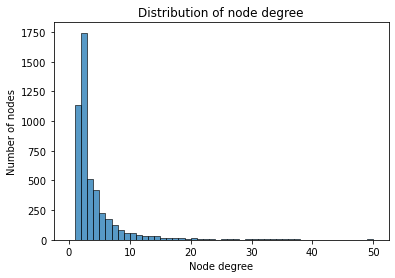

In [48]:
sns.histplot(node_degree['degree'],binwidth=1,binrange=[0,50])
plt.title('Distribution of node degree')
plt.xlabel('Node degree')
plt.ylabel('Number of nodes');

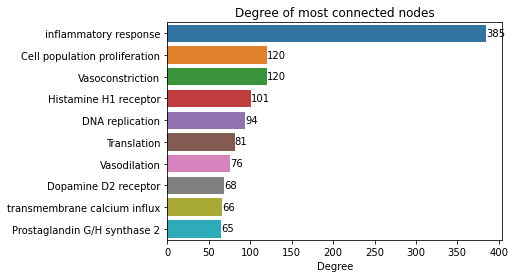

In [49]:
count_plot_h(node_degree.set_index('name')['degree'].head(10))
plt.title('Degree of most connected nodes');
plt.xlabel('Degree')
plt.ylabel('');